In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

# Question 1 Time Series Classification
## (c) Feature Extraction
### ii. create feature dataframe

In [21]:
def Create_Df(split=1):
    df = pd.read_csv('./data/cyc_dataset4.csv',skiprows=4,usecols=range(7))
    colname = ['instance']
    indexes = ['_min','_max','_mean','_median','_1stquarter','_2ndquarter','_3rdquarter']
    time = [count for count in range(split)]
    for name in df.columns.values[1:]:
        for index in indexes:
            for t in time:
                colname.append(name+index+'_'+str(t))
    return pd.DataFrame(np.zeros((88,42*split+1)),columns=colname)

In [22]:
def Fill_Df(path = './data',split = None):
    feature_df = Create_Df(split)
    for i,filename in zip(range(88),os.listdir(path)):
        df = pd.read_csv(os.path.join(path,filename),skiprows = 4, usecols = range(7))
        feature_df.loc[i,'instance']=filename
        for j in range(split):
            start = round(j/split*len(df))
            end = round((j+1)/split*len(df))
            for dfcol in df.columns[1:]:
                colset = [col for col in feature_df.columns.values if col.endswith('_'+str(j)) and dfcol in col]
                feature_df.loc[i,colset] = [
                min(df.loc[start:end,dfcol]),
                max(df.loc[start:end,dfcol]),
                np.mean(df.loc[start:end,dfcol]),
                np.median(df.loc[start:end,dfcol])
            ]+np.percentile(df.loc[start:end,dfcol],[25,50,70]).tolist()
    return feature_df

In [23]:
#Confidence Interval
def Bootstrap(data, B, c):
    array = np.array(data)
    n = len(array)
    sample_result_arr = []
    for i in range(B):
        index_arr = np.random.randint(0,n,size = n)
        data_sample = array[index_arr]
        sample_result = np.std(data_sample)
        sample_result_arr.append(sample_result)
    
    a = 1-c
    k1 = int(B * a/2)
    k2 = int(B - k1)
    auc_sample_arr_sorted = sorted(sample_result_arr)
    lower = auc_sample_arr_sorted[k1]
    higher = auc_sample_arr_sorted[k2]
    
    return lower, higher

In [60]:
def Processing(feature_df = None):    
    indexes = ['mean','max','median']
    factors = ['avg_rss12','var_rss12','var_rss23']
    cols = []
    for col in feature_df.columns:
        for index in indexes:
            for factor in factors:
                if factor in col:
                    if index in col:
                        cols.append(col)
    cols.append('feature')
    
    train_rows=[]
    indexes = [3,4,5,6,7,8,9,10,11,12,13,14,15]
    indexes = ['dataset'+str(i) for i in indexes]

    for row in feature_df['instance']:
        if 'bending' in row:
            for index in indexes:
                if index in row:
                    train_rows.append(row)
        else:
            for index in indexes[1:]:
                if index in row:
                    train_rows.append(row)
    train_rows = sorted(list(set(train_rows)))
    test_rows = sorted(list(set(feature_df['instance'])-set(train_rows)))

    feature_df.set_index(['instance'],inplace = True)

    bending = [i for i in feature_df._stat_axis.values if 'bending' in i]
    other = sorted(list(set(feature_df._stat_axis.values)-set(bending)))

    feature_df['feature']=None

    feature_df.loc[bending,'feature']=1
    feature_df.loc[other,'feature']=0

    train = feature_df.loc[train_rows,cols]
    test = feature_df.loc[test_rows,cols]
    
    return train, test

In [25]:
feature_df = Fill_Df(split=1)

### iii. Standard Deviation Calculation and Bootstrap

In [26]:
#Standard Deviation
std = pd.DataFrame(np.zeros((3,42)),columns = feature_df.columns.values[1:])
for col in std.columns:
    std.loc[1,col] = np.std(feature_df[col])
std

,avg_rss12_min_0,avg_rss12_max_0,avg_rss12_mean_0,avg_rss12_median_0,avg_rss12_1stquarter_0,avg_rss12_2ndquarter_0,avg_rss12_3rdquarter_0,var_rss12_min_0,var_rss12_max_0,var_rss12_mean_0,...,avg_rss23_1stquarter_0,avg_rss23_2ndquarter_0,avg_rss23_3rdquarter_0,var_rss23_min_0,var_rss23_max_0,var_rss23_mean_0,var_rss23_median_0,var_rss23_1stquarter_0,var_rss23_2ndquarter_0,var_rss23_3rdquarter_0
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,9.515445,4.369322,5.305314,5.409056,6.118526,5.409056,5.230389,0.0,5.033882,1.565194,...,6.061727,5.780655,5.5425,0.045577,2.504568,1.148232,1.080284,0.754261,1.080284,1.404336
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
for col in std.columns:
    std.loc[[0,2],col] = Bootstrap(feature_df[col],1000,0.90)
std

,avg_rss12_min_0,avg_rss12_max_0,avg_rss12_mean_0,avg_rss12_median_0,avg_rss12_1stquarter_0,avg_rss12_2ndquarter_0,avg_rss12_3rdquarter_0,var_rss12_min_0,var_rss12_max_0,var_rss12_mean_0,...,avg_rss23_1stquarter_0,avg_rss23_2ndquarter_0,avg_rss23_3rdquarter_0,var_rss23_min_0,var_rss23_max_0,var_rss23_mean_0,var_rss23_median_0,var_rss23_1stquarter_0,var_rss23_2ndquarter_0,var_rss23_3rdquarter_0
0,8.216466,3.359148,4.667956,4.767651,5.545999,4.796174,4.418966,0.0,4.622375,1.384609,...,4.749519,4.453511,4.345856,0.000000,2.238765,1.052247,0.989702,0.688145,0.995223,1.289848
1,9.515445,4.369322,5.305314,5.409056,6.118526,5.409056,5.230389,0.0,5.033882,1.565194,...,6.061727,5.780655,5.542500,0.045577,2.504568,1.148232,1.080284,0.754261,1.080284,1.404336
2,10.728573,5.230877,5.875071,5.987456,6.636028,5.973614,5.925613,0.0,5.361158,1.692746,...,7.177118,6.871535,6.597733,0.078029,2.727854,1.205147,1.140482,0.801822,1.144793,1.471218


I would choose Max, Mean and median.
## (d) Binary Classification Using Logistic Regression
### i. Scatter Plot
data process

C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\li chen\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


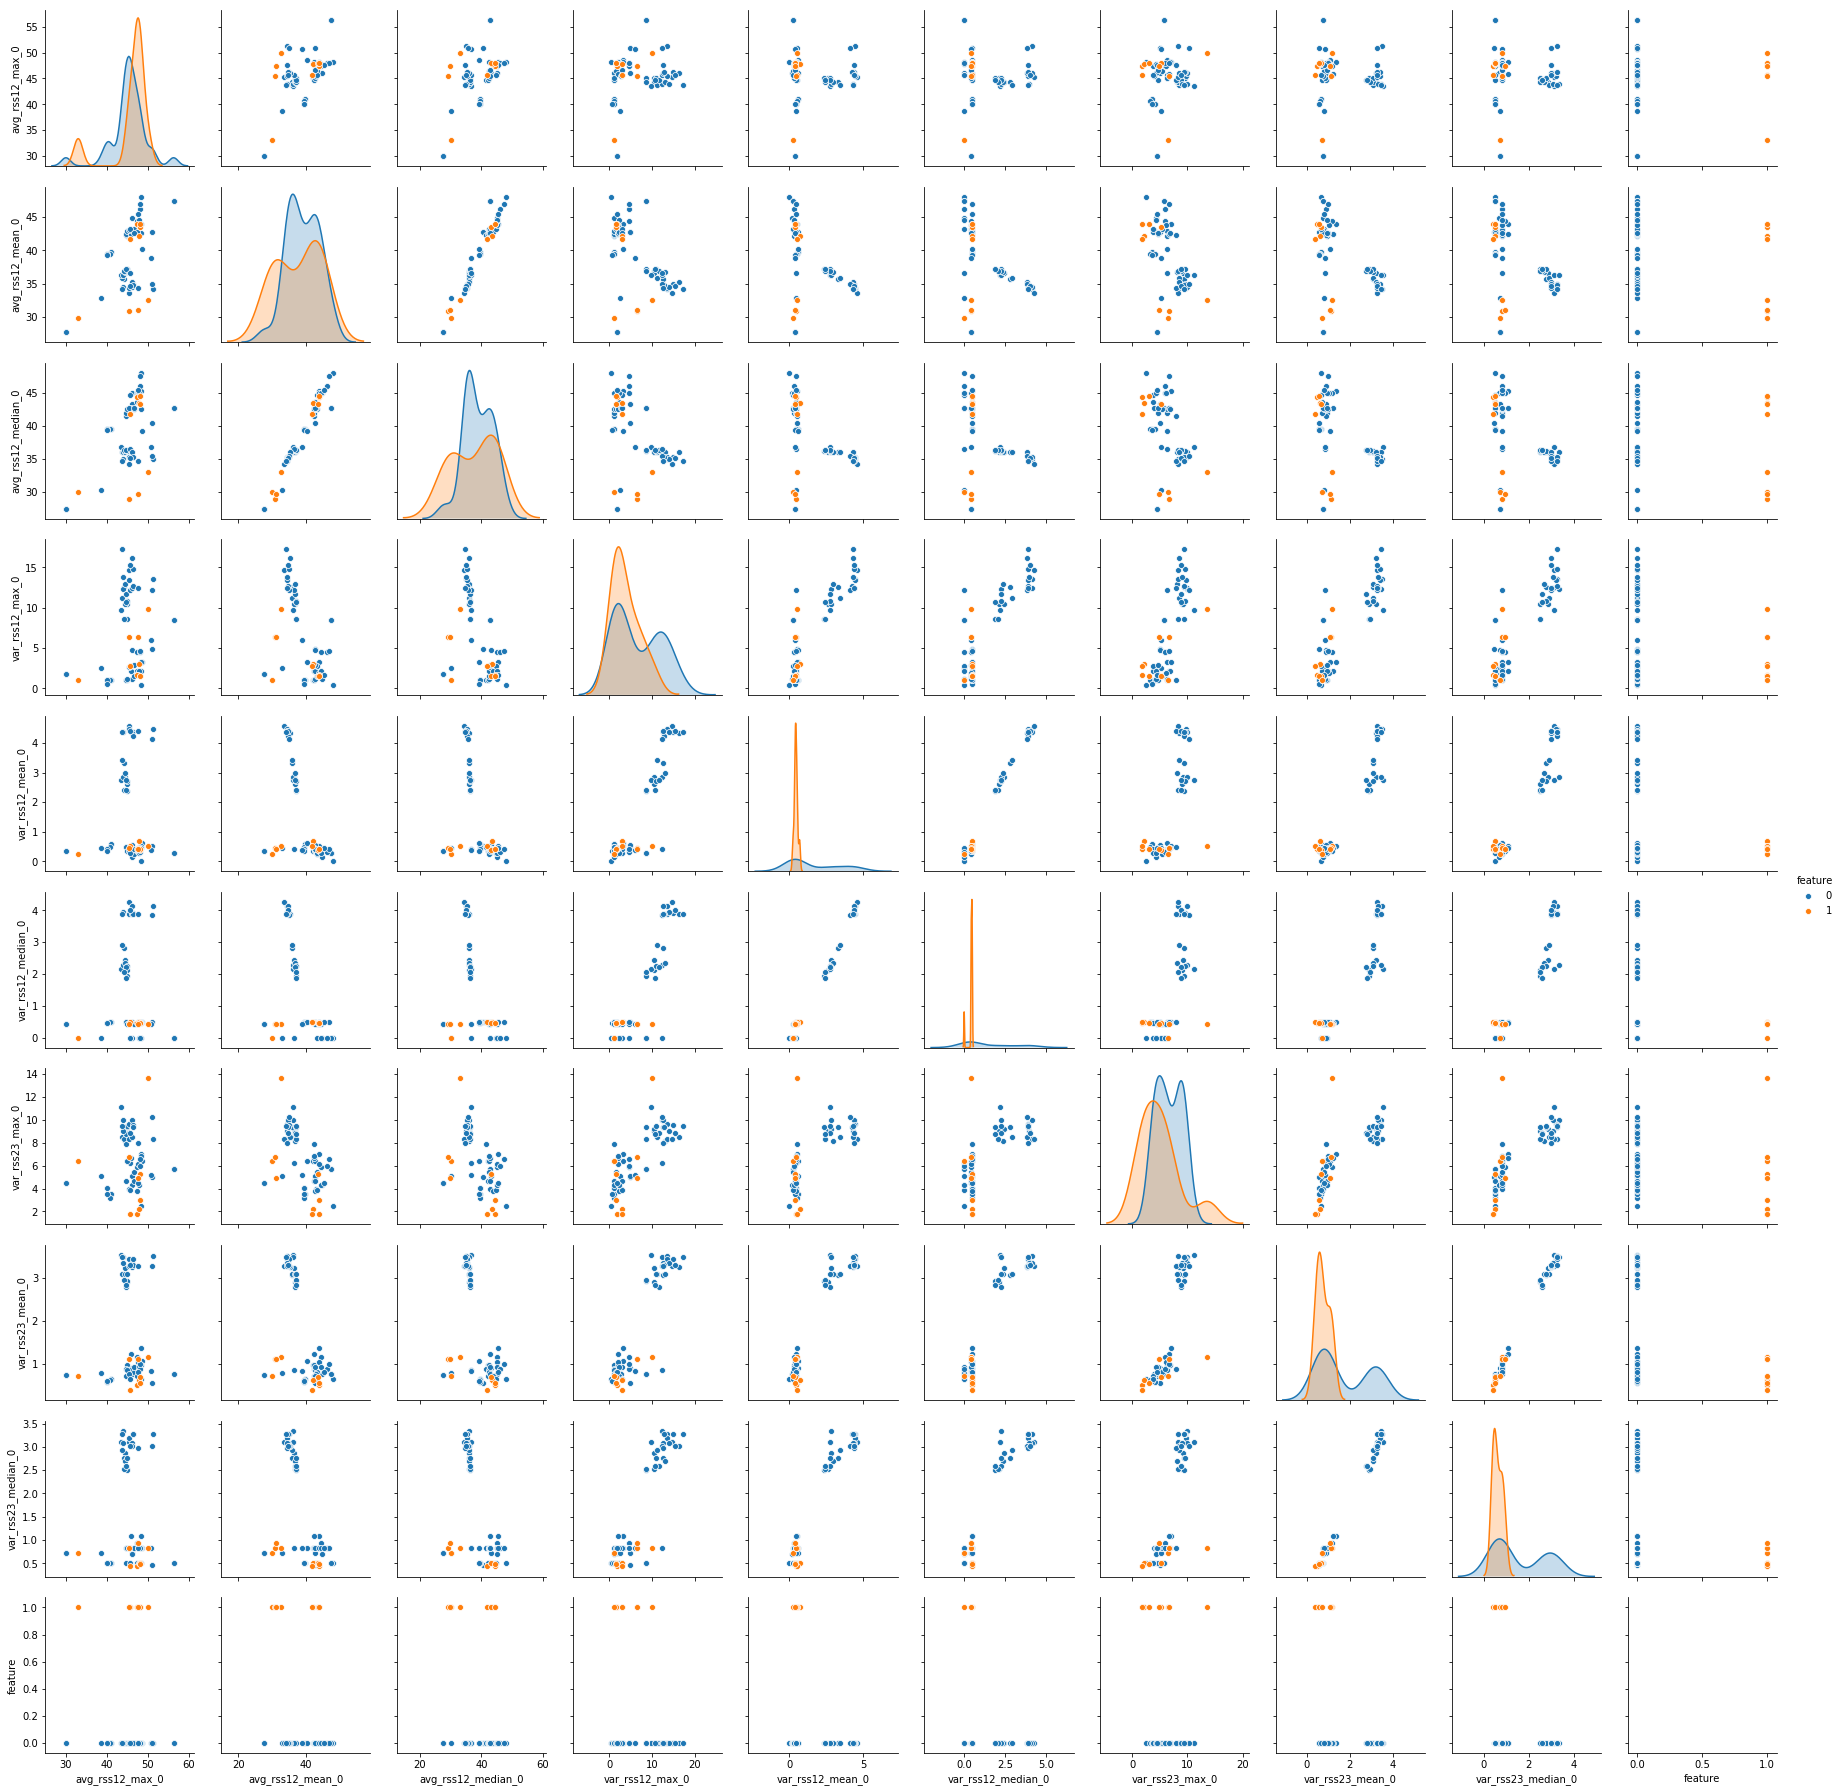

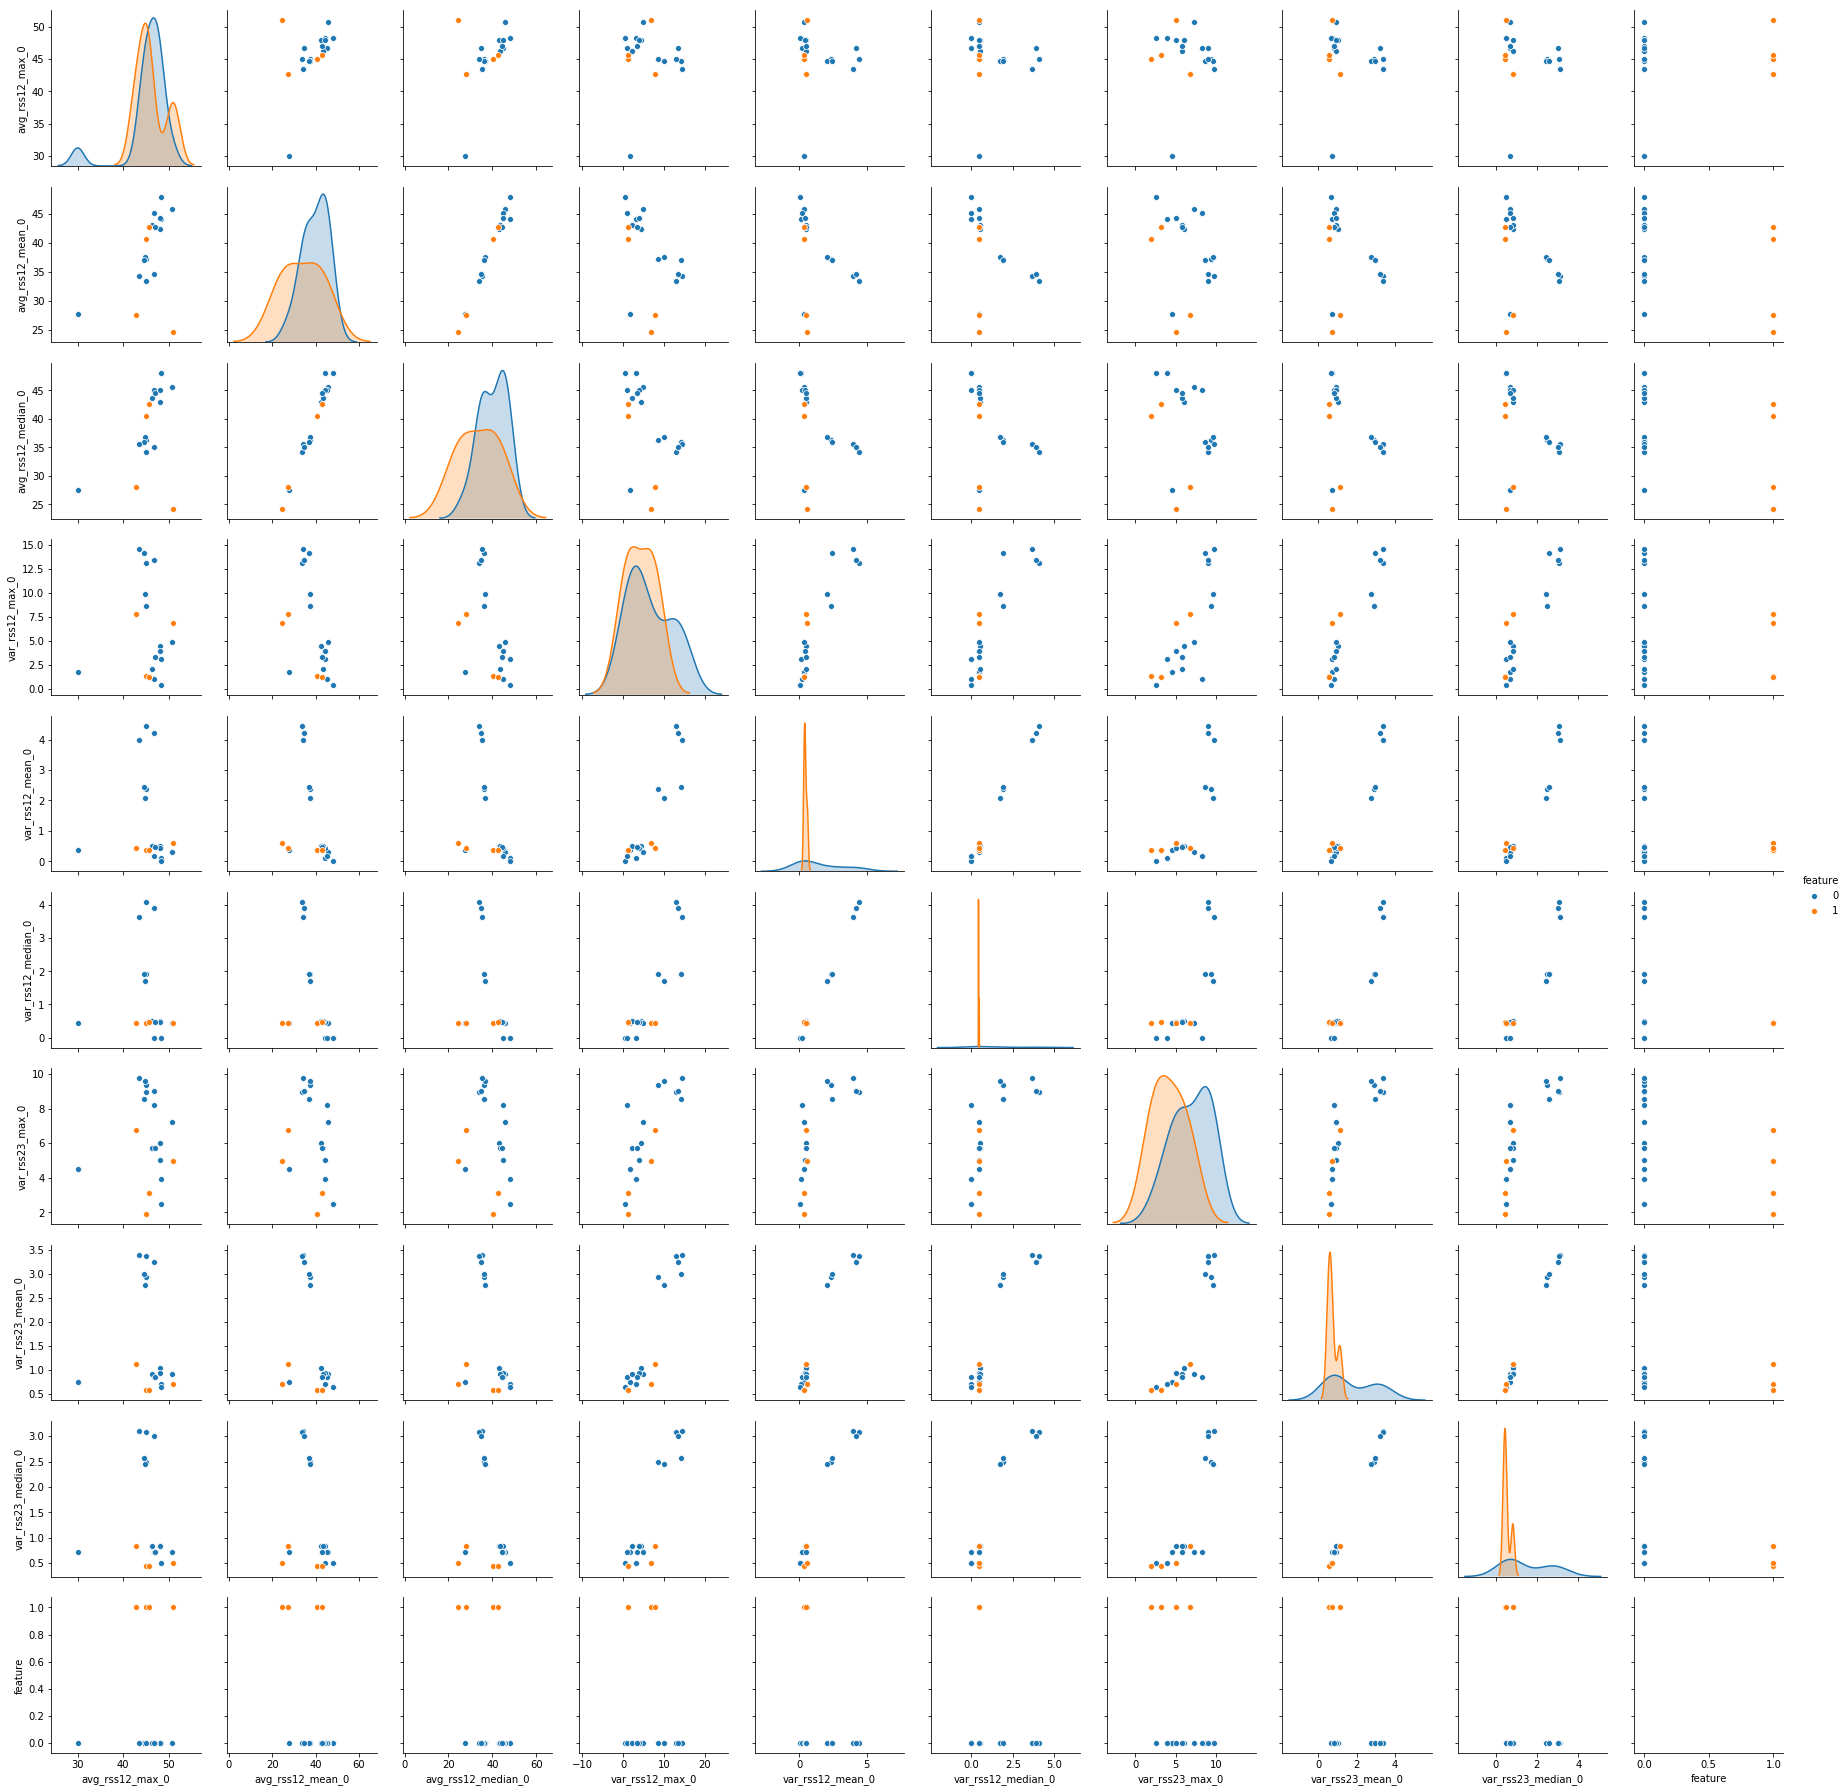

In [28]:
train,test = Processing(feature_df)
sns.pairplot(train,hue = 'feature')
sns.pairplot(test,hue='feature')

### ii. Scatter Plot After Break into 2 piece

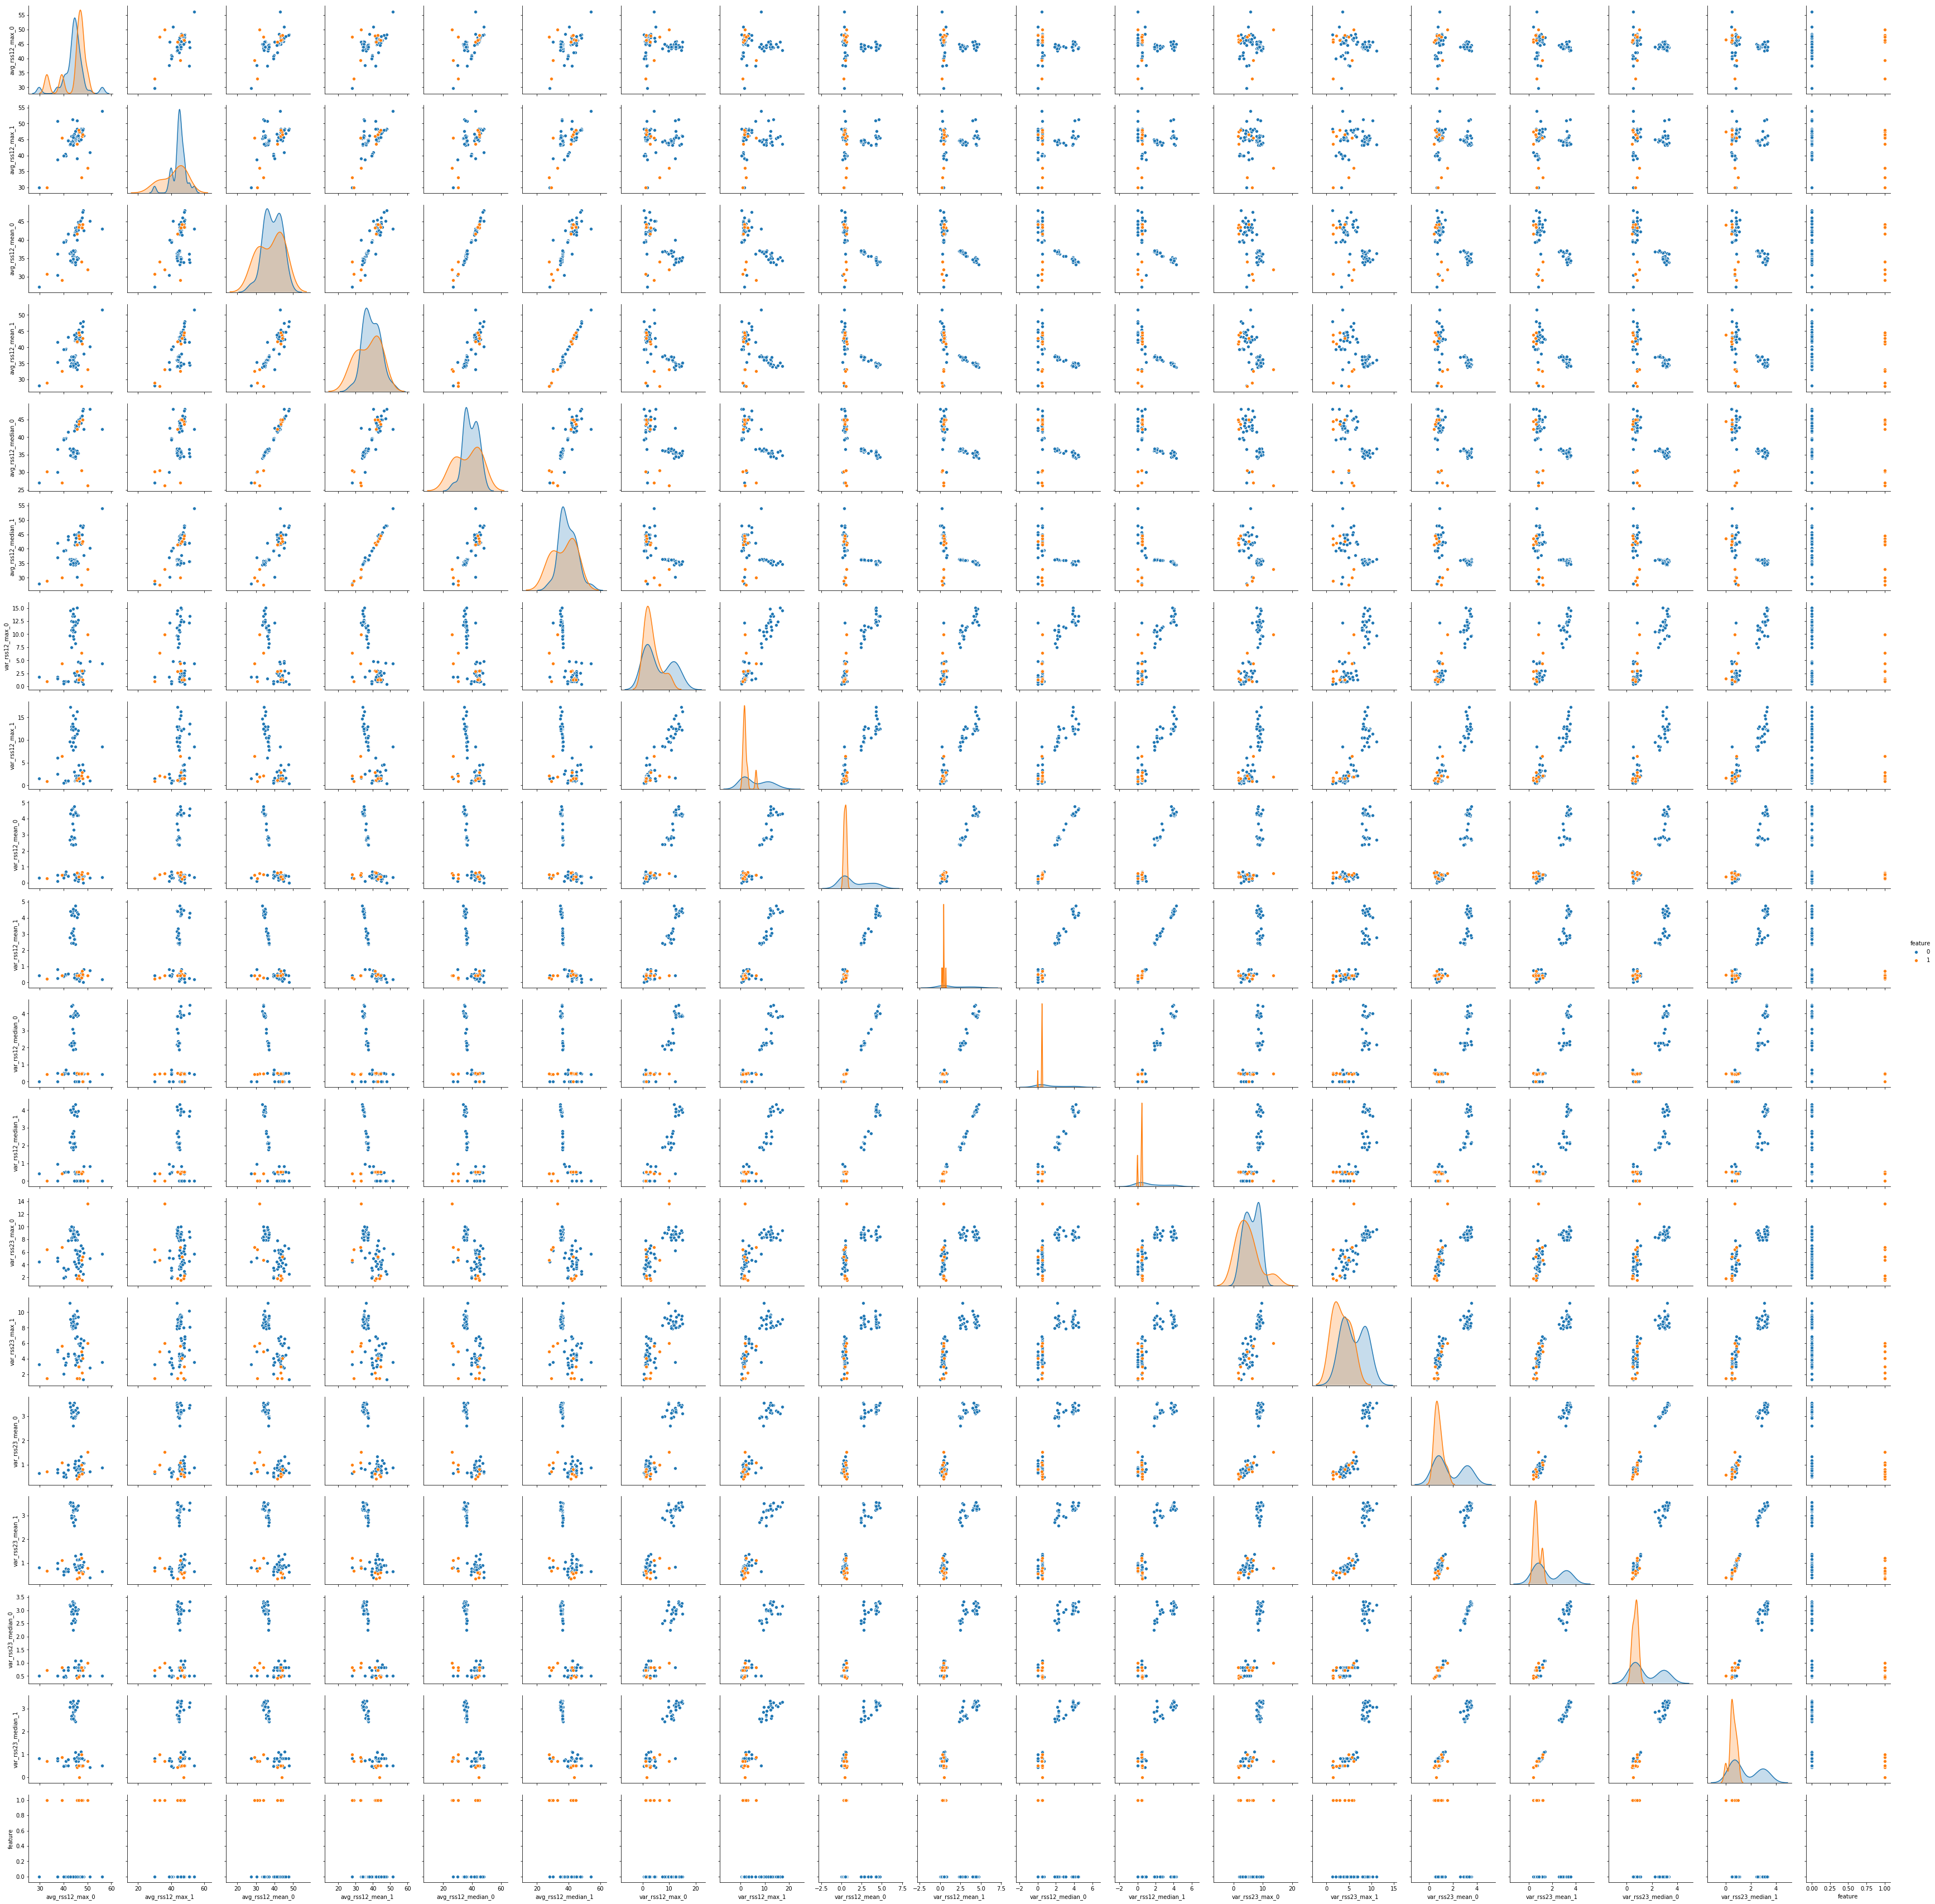

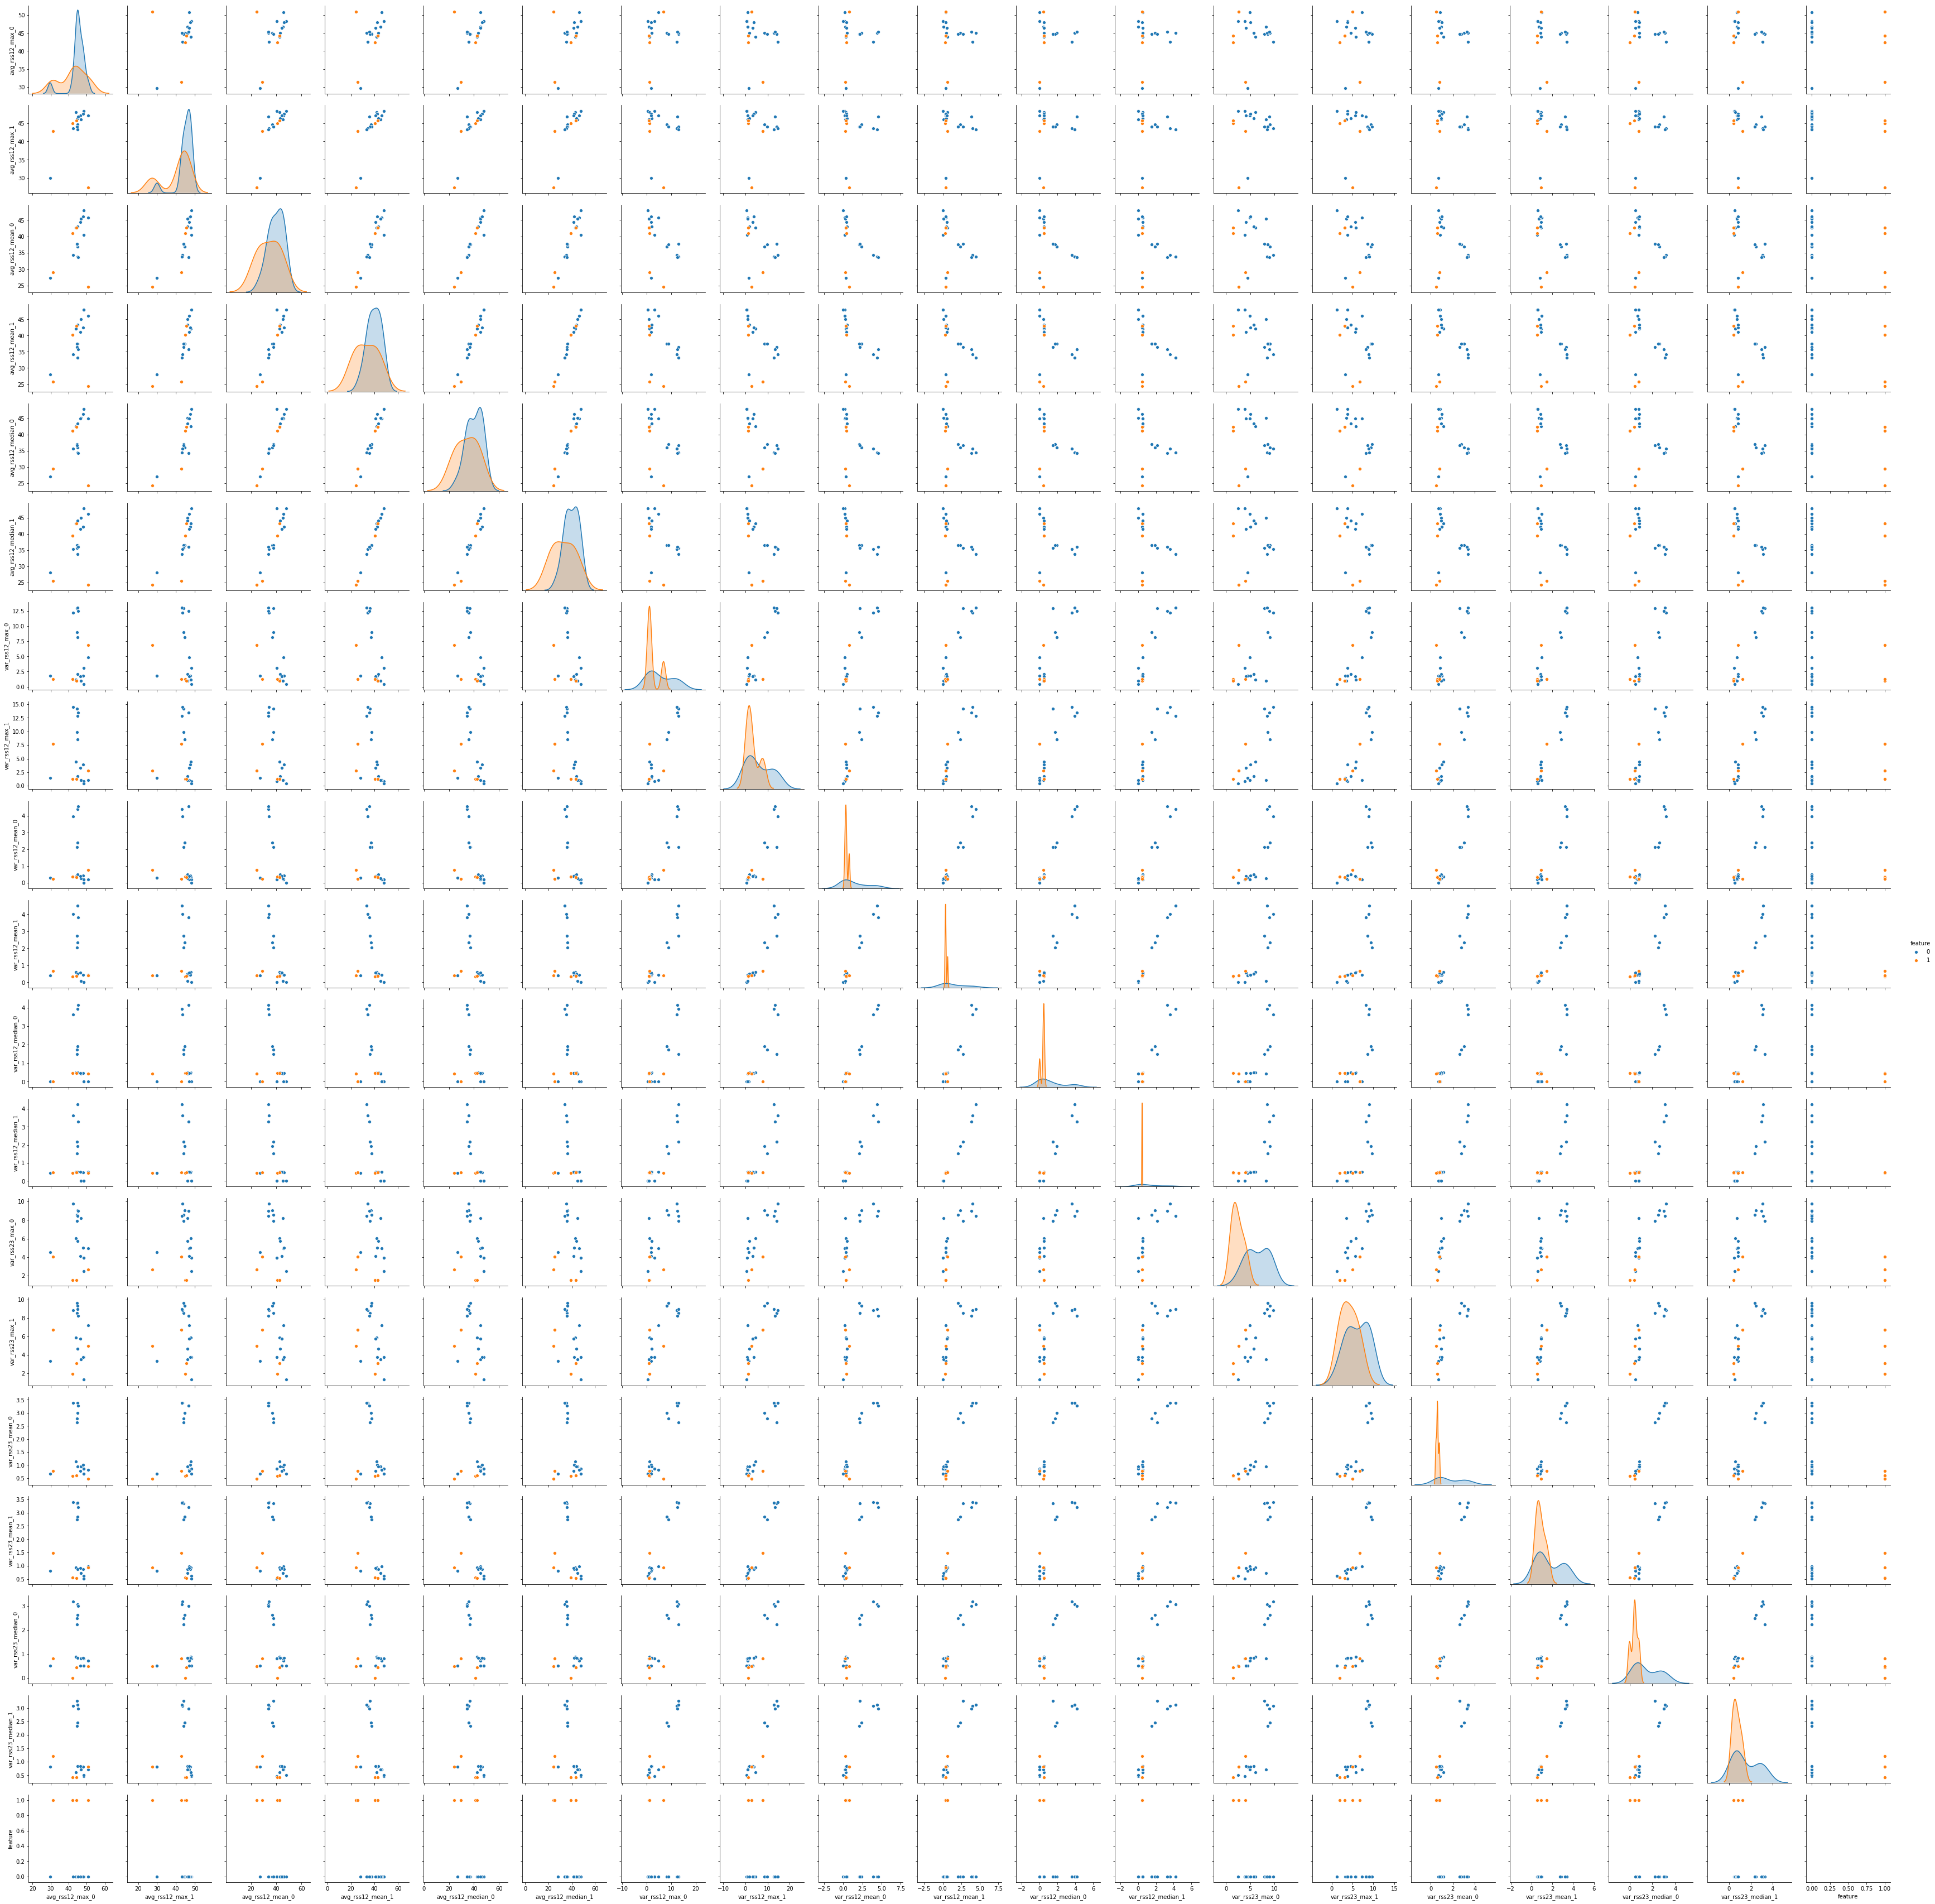

In [29]:
feature_df2 = Fill_Df(split=2)
train, test = Processing(feature_df = feature_df2)
sns.pairplot(train,hue = 'feature')
sns.pairplot(test,hue='feature')

### iii. Break into {1,2,3,4...20} pieces

In [65]:
def standardize(feature_df):
    train, test = Processing(feature_df)
    for df in [train,test]:
        for col in df.columns:
            if col !='feature':
                std = np.var(df.loc[:,col].values)**0.5
                mean = np.mean(df.loc[:,col].values)
                df[col] = (df[col]-mean)/std
    return train, test
def load_data(split = None):
    feature_df = Fill_Df(split = split)
    train, test = standardize(feature_df)
    train_x = train.loc[:,[i for i in train.columns if 'feature' not in i]].values
    train_y = train.loc[:,'feature'].values
    test_x = test.loc[:,[i for i in test.columns if 'feature' not in i]].values
    test_y = test.loc[:,'feature'].values
    return train_x, train_y, test_x, test_y


In [73]:
train_x, train_y, test_x, test_y = load_data(split = 5)

In [ ]:
log_reg = sm.Logit(train_y, train_x)
clf = log_reg.fit(method='bfgs')
print(clf.summary())
pred_y = np.array([round(i) for i in clf.predict(test_x).tolist()])


### iv confusion matrix, ROC and AUC

In [91]:
C = confusion_matrix(test_y,pred_y)

# Question2 3.7.4
## (a) 
We would expect the cubic model has lower RSS than cubic model. because there is an over fitting problem in the training set.
## (b)
We would expect the linear model has lower RSS than cubic model. because the real relationship between the dependent and independent variables are linear. therefore, nonlinear model would perform larger bias.
## (c)
cubic model will have lower RSS, since the real relationship is not linear, the cubic model will explain more than linear model.
## (d)
Not enough information
# Question3 4.7.3
Because X does not follow identicl variance assumption, the Bayes classifier is not linear but quadratic.
# Question4 
$$p = \frac{1}{e^{\frac{5}{18}}+1}$$